# Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

## Цели работы

**Цель** —разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) с использованием  PyTorch.

## Требования к результатам выполнения работы

1. Требования к структуре и содержимому Jupyter Notebook:
    - Загрузить и проверить данные (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей).
    - Реализовать архитектуру нейронной сеть с использованием фреймворка PyTorch.
    - Настроить гиперпараметры обучения (например, архитектуры, скорости обучения и размера пачки (batch size)).
    - Вывести ошибку классификации и точность на тренировочном наборе данных по окончании каждой эпохи.
    - Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучения после обучения.

2. Выбор архитектуры:
    - Необходимо использовать ***сверточные*** архитектуры нейронных сетей
    - Разрешается использовать как готовые архитектуры (например, VGG, ResNet и тд), так и архитектуры разработанные студентом самостоятельно.
    - Реализация должна быть выполнена с нуля в PyTorch, без использования готовых модулей (например, import Resnet недопустимо).

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## Загрузка набора данных

In [104]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Проверка корректности данных

In [105]:
print(f'Размер тренировочных данных: {train_loader.dataset.data.shape}')
print(f'Размер тестовых данных: {test_loader.dataset.data.shape}')

Размер тренировочных данных: (50000, 32, 32, 3)
Размер тестовых данных: (10000, 32, 32, 3)


#### Функция для визуализации изображений с соответствующими метками:

In [106]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [107]:
mean, std = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]

# Need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy()
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

def show_data(dataset):
    data_iterable = iter(dataset)
    images, labels = next(data_iterable)
    fig = plt.figure(figsize=(20, 20))

    for idx in np.arange(15):
        ax = fig.add_subplot(1, 15, idx+1, xticks=[], yticks=[])

        plt.imshow(im_convert(images[idx]))
        ax.set_title(classes[labels[idx].item()])

#### Демонстрация изображений и их меток из тренировочной выборки:

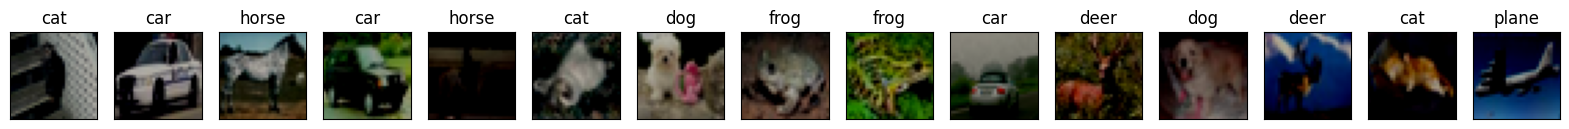

In [108]:
show_data(train_loader)

#### Демонстрация изображений и их меток из тестовой выборки:

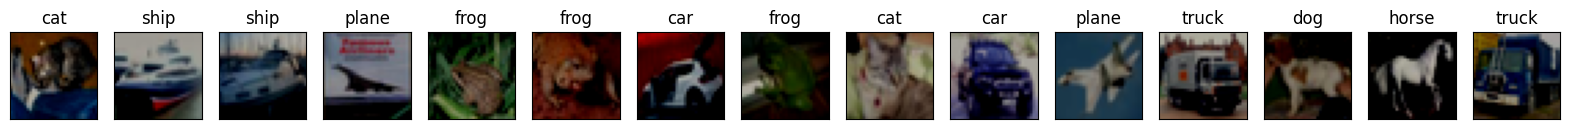

In [109]:
show_data(test_loader)

## ResNet

#### Остаточный блок

In [110]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

#### ResNet34

In [111]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet34(num_classes):
    return ResNet(ResidualBlock, [3, 4, 6, 3], num_classes)

## Настройка гиперпараметров

In [112]:
num_classes = 10
num_epochs = 50
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = ResNet34(num_classes).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

cuda


## Обучение

In [113]:
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    total = 0.0
    correct = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss_epoch = running_loss / len(train_loader)
    loss_list.append(loss_epoch)

    acc_epoch = correct / total
    acc_list.append(acc_epoch)

    elapsed_time = time.time() - start_time

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss = {loss_epoch:.4f}, Accuracy = {acc_epoch:.4f}')
    print(f'Time = {elapsed_time:.4f} seconds')
    print()

Epoch [1/50], Loss = 1.4624, Accuracy = 0.4766
Time = 33.7632 seconds

Epoch [2/50], Loss = 1.0590, Accuracy = 0.6297
Time = 33.6421 seconds

Epoch [3/50], Loss = 0.8609, Accuracy = 0.7011
Time = 33.2623 seconds

Epoch [4/50], Loss = 0.7514, Accuracy = 0.7416
Time = 33.7863 seconds

Epoch [5/50], Loss = 0.6729, Accuracy = 0.7680
Time = 33.8157 seconds

Epoch [6/50], Loss = 0.5612, Accuracy = 0.8038
Time = 33.4295 seconds

Epoch [7/50], Loss = 0.4880, Accuracy = 0.8304
Time = 34.0753 seconds

Epoch [8/50], Loss = 0.4210, Accuracy = 0.8540
Time = 33.9057 seconds

Epoch [9/50], Loss = 0.3432, Accuracy = 0.8803
Time = 33.7046 seconds

Epoch [10/50], Loss = 0.3151, Accuracy = 0.8920
Time = 33.6634 seconds

Epoch [11/50], Loss = 0.2376, Accuracy = 0.9163
Time = 34.1763 seconds

Epoch [12/50], Loss = 0.1916, Accuracy = 0.9336
Time = 34.0648 seconds

Epoch [13/50], Loss = 0.1639, Accuracy = 0.9430
Time = 33.4325 seconds

Epoch [14/50], Loss = 0.1298, Accuracy = 0.9556
Time = 33.8811 seconds

E

## Тестирование

In [116]:
model.eval()
correct = 0.0
total = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Accuracy of the model on the test images: 77.77%


## График ошибки обучения

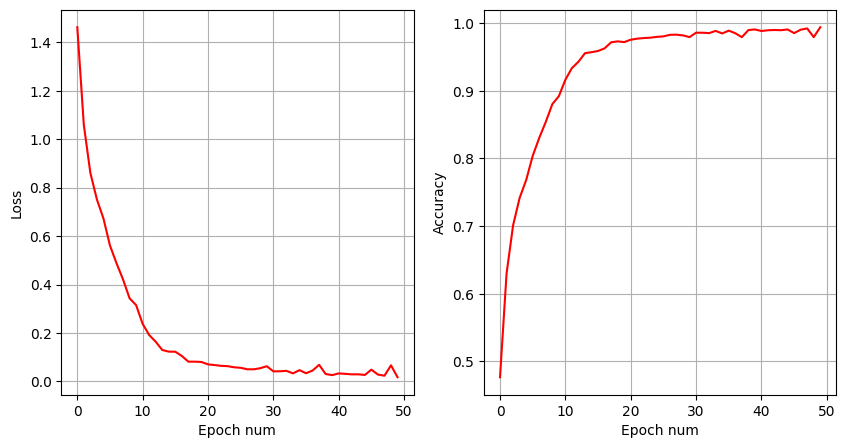

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(loss_list, 'r')
axs[0].set_xlabel('Epoch num')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

axs[1].plot(acc_list, 'r')
axs[1].set_xlabel('Epoch num')
axs[1].set_ylabel('Accuracy')
axs[1].grid(True)

plt.show()